In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, addcyclic, shiftgrid
import pymongo
from pprint import pprint
from datetime import datetime, timedelta, date
import pandas as pd
import gdal as gdl
import matplotlib.mlab as ml
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import Normalize

In [2]:
mongo_host_local = 'mongodb://localhost:27017/'
mg = pymongo.MongoClient(mongo_host_local)

In [3]:
db = mg.ECMWF
db.collection_names()

['system.indexes',
 'ERAINT_grid',
 'ERAINT_lores_grid',
 'ERAINT_lores_monthly_anom',
 'ERAINT_monthly',
 'ERAINT_lores_monthly']

In [4]:
ERA_vers = 'lores'
if (ERA_vers == 'hires'):
    col_dat = 'ERAINT_monthly'
    col_anom = 'ERAINT_monthly_anom'
    col_grid = 'ERAINT_grid'
    resolution = 0.25
elif (ERA_vers == 'lores'):
    col_dat = 'ERAINT_lores_monthly'
    col_anom = 'ERAINT_lores_monthly_anom'
    col_grid = 'ERAINT_lores_grid'
    resolution = 2.5

In [5]:
con_anom = db[col_anom]
fo = con_anom.find_one()
pprint(fo)

{'_id': ObjectId('5a46876b8cb6b8108790f64a'),
 'al': -2.7755575615628914e-17,
 'blh': 17.16410963120117,
 'ci': 0.00479535363874195,
 'd2m': -1.381832545858515,
 'date': datetime.datetime(1979, 3, 1, 0, 0),
 'hcc': -0.003499210088334481,
 'id_grid': 1,
 'ie': 0.0,
 'ishf': -6.802686632924173,
 'istl1': -0.6554408397386169,
 'lcc': 0.09395961846049472,
 'mcc': 0.1201171896552547,
 'month': 3,
 'msl': -1286.3445712374814,
 'si10': -0.9742091376525144,
 'skt': -0.70064309868485,
 'sp': -1285.586603789896,
 'sst': -1.7053025658242404e-13,
 'stl1': -0.6713863041083243,
 't2m': -1.5088453972467164,
 'u10': -3.921264344805355,
 'v10': 2.6433083071635384,
 'year': 1979,
 'z70': -1312.067142538639}


In [6]:
con_grid = db[col_grid]
fo = con_grid.find_one()
pprint(fo)

{'_id': ObjectId('5a1882228cb6b815bce38f92'),
 'id_grid': 1,
 'loc': {'coordinates': [-180.0, 90.0], 'type': 'Point'}}


- The domain north of 20°N is chosen for EOF decomposition for Z70 hPa and SIC to focus on the extra-tropical variability 
- The area north of 20°S is chosen for SST to also include key regions of tropical SST variability
- Query id_grid encompassed in the domain. Be careful: defining a simple box won't work on the sphere, see [Antimeridian Cutting](https://tools.ietf.org/html/rfc7946#section-3.1.9). In addition, a vertice will follow the shorterst path on the sphere. Hence, we need to define a proper circular path for both latmin and latmax.



In [7]:
this_box = {'lonmin': -180, 'lonmax': 180, 'latmin': 20, 'latmax': 90}
def genCircle(start_lon, stop_lon, lat, decreasing): 
    res = map(lambda x:[int(x), lat],
              sorted(np.arange(start=start_lon, stop=stop_lon+1), reverse=decreasing))
    return list(res)
bb = genCircle(start_lon=this_box['lonmin'], stop_lon=this_box['lonmax'], lat=10, decreasing=True)
circle_north_pos = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                              lat = this_box['latmax'], decreasing = False)
circle_south_neg = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                            lat = this_box['latmin'],  decreasing = True)
slp_poly = [[this_box['lonmin'], this_box['latmin']]]
slp_poly.extend(circle_north_pos)
slp_poly.extend(circle_south_neg)
this_polygon = slp_poly
geo_qry = {"loc": 
           {"$geoWithin": {
               "$geometry": {
                   "type": "Polygon",
                   "coordinates": [this_polygon]
               }
           }}}

res = con_grid.find(filter = geo_qry, projection = {"_id":0, "id_grid": 1, "loc": 1})
grid_df = pd.DataFrame(list(res))
grid_ids = grid_df.id_grid.values
grid_ids[:10]

array([4095, 4087, 3945, 4089, 4091, 3947, 3946, 3802, 3803, 3659])

# Query the anomaly collection for the requested id_grids

In [8]:
# Query z70 in the anomaly collection for a given day for the grid_ids
this_date = datetime(1988, 12, 1, 0, 0)
res = con_anom.find(filter = {
    "date": this_date,
    "id_grid": {"$in": grid_ids.tolist()}},
                       projection = {"_id":0, "id_grid": 1, "z70": 1})
anom_df = pd.DataFrame(list(res))
anom_df.head()

,id_grid,z70
0,1940,-1533.335412
1,1941,-1543.809612
2,1942,-1540.757342
3,1943,-1527.688561
4,1944,-1506.417387


In [9]:
# Merge anom_df with grid_df:
anom_dat = pd.merge(left=anom_df, right=grid_df, on = "id_grid")
anom_dat.head()

,id_grid,z70,loc
0,1940,-1533.335412,"{'type': 'Point', 'coordinates': [-12.5, 57.5]}"
1,1941,-1543.809612,"{'type': 'Point', 'coordinates': [-10.0, 57.5]}"
2,1942,-1540.757342,"{'type': 'Point', 'coordinates': [-7.5, 57.5]}"
3,1943,-1527.688561,"{'type': 'Point', 'coordinates': [-5.0, 57.5]}"
4,1944,-1506.417387,"{'type': 'Point', 'coordinates': [-2.5, 57.5]}"


# Plot random day

In [10]:
ras_df = anom_dat.assign(lon = list(map(lambda x: 
                                       x[0]['coordinates'][0],
                                       anom_dat[['loc']].values)),
                        lat = list(map(lambda x: 
                                       x[0]['coordinates'][1],
                                       anom_dat[['loc']].values))
                       ).pipe(lambda x: x[['lon', 'lat', 'z70']])

ras_df.head()

,lon,lat,z70
0,-12.5,57.5,-1533.335412
1,-10.0,57.5,-1543.809612
2,-7.5,57.5,-1540.757342
3,-5.0,57.5,-1527.688561
4,-2.5,57.5,-1506.417387


The solution to the rasterization problem was found here: 
https://matplotlib.org/examples/pylab_examples/griddata_demo.html

In [11]:
lons = np.arange(start=-180, stop=180+1, step=resolution)
lats = np.arange(start=-90, stop=90+1, step=resolution)
this_field = ml.griddata(x = ras_df.lon.values,
                 y = ras_df.lat.values,
                 z = ras_df.z70.values,
                 xi = lons,
                 yi = lats,
                 interp='nn')
this_field

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [1660.2876532091766 1665.078074171824 1668.767702918396 ...,
  1648.1943656334204 1654.562863327517 --]
 [1581.4595184608604 1583.6106712694384 1585.4976528848206 ...,
  1576.5626323201034 1578.1389661012863 --]
 [-- 1499.9338903333578 1499.934642818728 ..., 1499.9432249304073
  1499.9866866877298 --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [False False False ..., False False  True]
 [False False False ..., False False  True]
 [ True False False ..., False False  True]],
       fill_value = 1e+20)

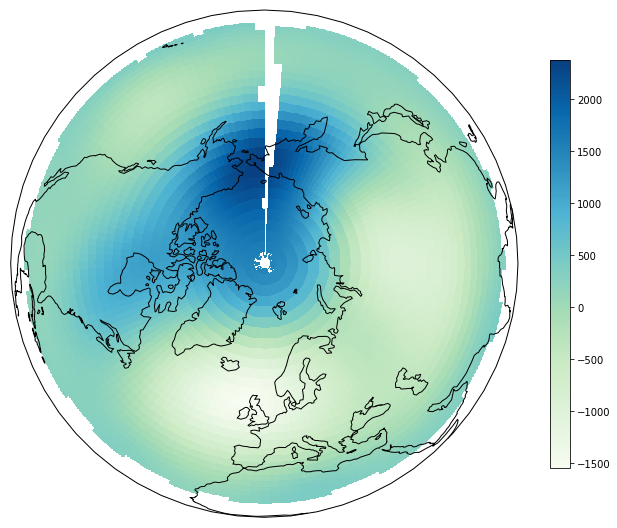

In [12]:
# Plot itself
this_proj = ccrs.Orthographic(0, 90)
fig = plt.figure(figsize=(25, 25))
ax = plt.subplot(1, 2, 1, projection=this_proj)
ax.coastlines(zorder=3)
img_proj = ccrs.PlateCarree()
img_extent = (-180, 180, -90, 90)
im = ax.imshow(this_field, 
               transform=img_proj,
               extent=img_extent, 
               origin='lower', 
               zorder=2,
               cmap='GnBu')
plt.colorbar(im, orientation='vertical',ticklocation='auto', shrink=0.3)
plt.show()

# Perform Principal Component Analyis

In [13]:
#from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

Query all data above 20° Lat and belonging to months sept, oct, nov, dec, jan, fev.

In [14]:
res = con_anom.aggregate(pipeline=[ 
    {"$project": {"id_grid": 1, "date": 1, "z70": 1, "month": {"$month": "$date"}}},
    {"$match": {"month": {"$in": [9, 10, 11, 12, 1, 2]},
                "id_grid": {"$in": grid_ids.tolist()} }},
    {"$project": {"_id": 0, "id_grid": 1, "date": 1, "z70": 1}} ])    
anom_df = pd.DataFrame(list(res))

In [15]:
anom_df.head()

,date,id_grid,z70
0,2017-02-01,1,860.989719
1,2017-01-01,1,1719.850903
2,2016-12-01,1,-1497.675093
3,2016-11-01,1,-3279.428035
4,2016-10-01,1,-1495.140184


In [16]:
anom_df.tail()

,date,id_grid,z70
943915,1979-11-01,4175,79.690410
943916,1979-10-01,4175,-142.443858
943917,1979-09-01,4175,-36.490477
943918,1979-02-01,4175,203.091041
943919,1979-01-01,4175,-144.809993


In [17]:
anom_df.shape

(943920, 3)

Transform the DataFrame into a Maxtrix

In [18]:
X_df = anom_df.pivot(index='date', columns='id_grid', values='z70')
X_df.head()

id_grid,1,2,3,4,5,6,7,8,9,10,...,4157,4159,4161,4163,4165,4167,4169,4171,4173,4175
date,,,,,,,,,,,,,,,,,,,,,
1979-01-01,-1403.366369,-1403.366369,-1403.366369,-1403.366369,-1403.366369,-1403.366369,-1403.366369,-1403.366369,-1403.366369,-1403.366369,...,-148.377692,-144.200578,-141.850962,-139.651933,-136.696149,-136.096225,-137.513862,-141.576053,-142.866871,-144.809993
1979-02-01,-571.303223,-571.303223,-571.303223,-571.303223,-571.303223,-571.303223,-571.303223,-571.303223,-571.303223,-571.303223,...,87.221865,74.244591,63.469283,51.223433,45.538835,54.017156,75.519704,104.756766,144.834690,203.091041
1979-09-01,-696.929376,-696.929376,-696.929376,-696.929376,-696.929376,-696.929376,-696.929376,-696.929376,-696.929376,-696.929376,...,-67.707858,-61.759764,-60.448955,-55.158012,-52.029720,-44.981171,-41.599113,-37.675399,-36.043313,-36.490477
1979-10-01,-384.207184,-384.207184,-384.207184,-384.207184,-384.207184,-384.207184,-384.207184,-384.207184,-384.207184,-384.207184,...,-87.275002,-105.904315,-120.652319,-133.032568,-133.344507,-134.807818,-130.660029,-130.208642,-136.305313,-142.443858
1979-11-01,-675.590386,-675.590386,-675.590386,-675.590386,-675.590386,-675.590386,-675.590386,-675.590386,-675.590386,-675.590386,...,-70.082679,-82.711226,-88.677085,-85.589811,-78.234859,-61.148002,-28.123321,12.775863,47.258536,79.690410


In [19]:
pca = PCA(n_components=3)
pca.fit(X_df)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [20]:
# Explained variance :
pca.explained_variance_ratio_

array([ 0.66685266,  0.09820125,  0.0846545 ])

In [21]:
# components_ : array, shape (n_components, n_features)
pca.components_

array([[-0.03110221, -0.03110221, -0.03110221, ...,  0.00027295,
         0.00029251,  0.00032484],
       [-0.00544844, -0.00544844, -0.00544844, ...,  0.00305414,
         0.00316733,  0.00329759],
       [-0.00026355, -0.00026355, -0.00026355, ...,  0.00063796,
         0.00064253,  0.00058826]])

Let's plot the loadings

In [22]:
#loadings_df0 = pd.DataFrame(pca.components_.T, index=X_df.columns, columns=['loadings_1', 'loading_2', 'loading_3'])
loadings_df0 = pd.DataFrame(pca.components_.T, columns=['loadings_1', 'loading_2', 'loading_3'])
loadings_df0 = loadings_df0.assign(id_grid=X_df.columns)
loadings_df0.head()

,loadings_1,loading_2,loading_3,id_grid
0,-0.031102,-0.005448,-0.000264,1
1,-0.031102,-0.005448,-0.000264,2
2,-0.031102,-0.005448,-0.000264,3
3,-0.031102,-0.005448,-0.000264,4
4,-0.031102,-0.005448,-0.000264,5


loadings_df0 = pd.DataFrame({
    'id_grid': X_df.columns,
    'loading_1': pca.components_[0],
    'loading_2': pca.components_[1],
    'loading_3': pca.components_[2]})
    loadings_df0.head()

In [23]:
grid_df.head()

,id_grid,loc
0,4095,"{'type': 'Point', 'coordinates': [-25.0, 20.0]}"
1,4087,"{'type': 'Point', 'coordinates': [-45.0, 20.0]}"
2,3945,"{'type': 'Point', 'coordinates': [-40.0, 22.5]}"
3,4089,"{'type': 'Point', 'coordinates': [-40.0, 20.0]}"
4,4091,"{'type': 'Point', 'coordinates': [-35.0, 20.0]}"


In [24]:
loadings_df = pd.merge(left=loadings_df0, right=grid_df)
loadings_df.head()

,loadings_1,loading_2,loading_3,id_grid,loc
0,-0.031102,-0.005448,-0.000264,1,"{'type': 'Point', 'coordinates': [-180.0, 90.0]}"
1,-0.031102,-0.005448,-0.000264,2,"{'type': 'Point', 'coordinates': [-177.5, 90.0]}"
2,-0.031102,-0.005448,-0.000264,3,"{'type': 'Point', 'coordinates': [-175.0, 90.0]}"
3,-0.031102,-0.005448,-0.000264,4,"{'type': 'Point', 'coordinates': [-172.5, 90.0]}"
4,-0.031102,-0.005448,-0.000264,5,"{'type': 'Point', 'coordinates': [-170.0, 90.0]}"


In [25]:
ras_df = loadings_df.assign(lon = list(map(lambda x: 
                                       x[0]['coordinates'][0],
                                       loadings_df[['loc']].values)),
                        lat = list(map(lambda x: 
                                       x[0]['coordinates'][1],
                                       loadings_df[['loc']].values))
                       ).pipe(lambda x: x[['lon', 'lat', 'loading_2']])

ras_df.head()

,lon,lat,loading_2
0,-180.0,90.0,-0.005448
1,-177.5,90.0,-0.005448
2,-175.0,90.0,-0.005448
3,-172.5,90.0,-0.005448
4,-170.0,90.0,-0.005448


In [26]:
this_field = ml.griddata(
    x = ras_df.lon.values,
    y = ras_df.lat.values,
    z = ras_df.loading_2.values,
    xi = lons,
    yi = lats,
    interp='nn')
this_field

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-0.00834824646163456 -0.00783427519185937 -0.00730858803517919 ...,
  -0.009328437679317908 -0.0088478806430978 --]
 [-0.006661752902596759 -0.006414539611720502 -0.006161547053743431 ...,
  -0.007144439765234159 -0.007051386161687819 --]
 [-- -0.00544845088797374 -0.0054484530135896474 ...,
  -0.0054487315564425015 -0.005449479711064204 --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [False False False ..., False False  True]
 [False False False ..., False False  True]
 [ True False False ..., False False  True]],
       fill_value = 1e+20)

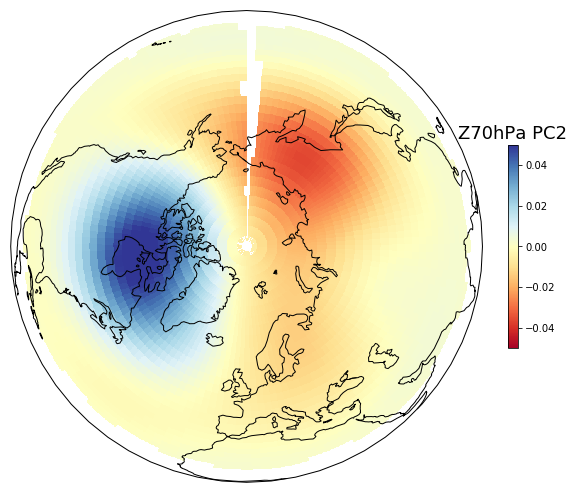

In [27]:
fig = plt.figure(figsize=(20, 20))
img_extent = (-180, 180,-90, 90) # because we *do have* defined lats on -90, +90 !!
ax = plt.subplot(1, 2, 1, projection=ccrs.Orthographic(0, 90))
ax.coastlines()

vmin, vmax = -0.05, 0.05
norm = Normalize(vmin=vmin, vmax=vmax)
n_cmap = cm.ScalarMappable(norm=norm, cmap="RdYlBu")
n_cmap.set_array([])
cbar = ax.get_figure().colorbar(n_cmap, ax=ax, orientation='vertical', fraction=0.02)
cbar.ax.set_title('Z70hPa PC2', fontdict={'fontsize': 18})

im = plt.imshow(X=this_field,
                vmin=vmin, vmax=vmax,
           transform=ccrs.PlateCarree(), 
           extent=img_extent,
           origin='lower', # This option is important !
           cmap='RdYlBu')
#plt.colorbar(im, orientation='vertical',ticklocation='auto', shrink=0.3, cmap="RdYlBu")
plt.show()

# Generic function to query a variable and extract PCA

In [28]:
# Generic function to query grid ids above a given latitude
def genCircle(start_lon, stop_lon, lat, decreasing): 
    res = map(lambda x:[int(x), lat],
              sorted(np.arange(start=start_lon, stop=stop_lon+1), reverse=decreasing))
    return list(res)

def queryGrids(aboveLat):
    this_box = {'lonmin': -180, 'lonmax': 180, 'latmin': aboveLat, 'latmax': 90}
    circle_north_pos = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                                  lat = this_box['latmax'], decreasing = False)
    circle_south_neg = genCircle(start_lon = this_box['lonmin'], stop_lon = this_box['lonmax'], 
                                lat = this_box['latmin'],  decreasing = True)
    slp_poly = [[this_box['lonmin'], this_box['latmin']]]
    slp_poly.extend(circle_north_pos)
    slp_poly.extend(circle_south_neg)
    this_polygon = slp_poly
    
    if aboveLat > 0:
        geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": [this_polygon]
               }}}}
    else: # case of a big polygon larger than one hemisphere
        geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": [list(reversed(this_polygon))], # the orientation matters
                       "crs": {
                           "type": "name", 
                           "properties": { "name": "urn:x-mongodb:crs:strictwinding:EPSG:4326" }
                       }
                   }
               }}}
        
    res = con_grid.find(filter = geo_qry, projection = {"_id":0, "id_grid": 1, "loc": 1})
    grid_df = pd.DataFrame(list(res))
    return grid_df

grid_df_20N = queryGrids(aboveLat=20)
grid_df_20S = queryGrids(aboveLat=-20)

In [29]:
# 3rd region for SST in Northern Atlantic, as in Promet (2008).
def getGridIds(this_polygon):
    geo_qry = {"loc": 
               {"$geoWithin": {
                   "$geometry": {
                       "type": "Polygon",
                       "coordinates": this_polygon
                   }
               }}}

    res = con_grid.find(filter = geo_qry, projection = {"_id":0, "id_grid": 1, "loc": 1})
    grid_df = pd.DataFrame(list(res))
    return grid_df
poly_NAtlantic = [list(reversed([ [-100,0], [-100,45],[-100,89], [20,89],[20,45],[20,0], [-100,0]]))]
grid_df_NAtlantic = getGridIds(poly_NAtlantic)
grid_ids_NAtlantic = grid_df_NAtlantic.id_grid.values

In [30]:
def queryLoadings(this_variable, this_grid_df, this_loading):
    # Query data anomalies
    grid_ids = this_grid_df.id_grid.values
    res = con_anom.aggregate(pipeline=[ 
    {"$project": {"id_grid": 1, "date": 1, this_variable: 1, "month": {"$month": "$date"}}},
    {"$match": {"month": {"$in": [9, 10, 11, 12, 1, 2]},
                "id_grid": {"$in": grid_ids.tolist()} }},
    {"$project": {"_id": 0, "id_grid": 1, "date": 1, this_variable: 1}} ])    
    anom_df = pd.DataFrame(list(res))

    # Transform
    X_df = anom_df.pivot(index='date', columns='id_grid', values=this_variable)
    pca = PCA(n_components=3)
    pca.fit(X_df)
    loadings_df0 = pd.DataFrame(pca.components_.T, columns=['loading_1', 'loading_2', 'loading_3'])
    loadings_df0 = loadings_df0.assign(id_grid=X_df.columns)
    loadings_df = pd.merge(left=loadings_df0, right=this_grid_df)
    ras_df = loadings_df.assign(lon = list(map(lambda x: 
                                           x[0]['coordinates'][0],
                                           loadings_df[['loc']].values)),
                            lat = list(map(lambda x: 
                                           x[0]['coordinates'][1],
                                           loadings_df[['loc']].values))
                           ).pipe(lambda x: x[['lon', 'lat', this_loading]])

    this_field = ml.griddata(
        x = ras_df.lon.values,
        y = ras_df.lat.values,
        z = ras_df[this_loading].values,
        xi = lons,
        yi = lats,
        interp='nn')
    
    if this_variable == 'z70':
        this_proj = ccrs.Orthographic(0, 90)
        vmin, vmax = -0.05, 0.05
        fs = 18
        cbartitle = 'Z70hPa PC2'
    elif this_variable == 'ci':
        this_proj = ccrs.Orthographic(0, 90)
        vmin, vmax = -0.15, 0.15
        cbartitle = 'SIC PC1'
        fs = 18
    elif this_variable == 'sst':
        this_proj = ccrs.PlateCarree()
        vmin, vmax = -0.08, 0.08
        cbartitle = 'SST PC3'
        fs = 14
    
    fig = plt.figure(figsize=(20, 20))
    img_extent = (-180, 180,-90, 90) # because we *do have* defined lats on -90, +90 !!
    ax = plt.subplot(1, 2, 1, projection=this_proj)
    ax.coastlines()
    
    norm = Normalize(vmin=vmin, vmax=vmax)
    n_cmap = cm.ScalarMappable(norm=norm, cmap="RdYlBu")
    n_cmap.set_array([])
    cbar = ax.get_figure().colorbar(n_cmap, ax=ax, orientation='vertical', fraction=0.02)
    cbar.ax.set_title(cbartitle, fontdict={'fontsize': fs})
    
    
    im = plt.imshow(X=this_field,
                    vmin=vmin, vmax=vmax,
                    transform=ccrs.PlateCarree(), 
                    extent=img_extent,
                    origin='lower', # This option is important !
                    cmap='RdYlBu')
    #plt.colorbar(im, orientation='vertical',ticklocation='auto', shrink=0.3, cmap="RdYlBu")
    plt.show()
    return(pca)

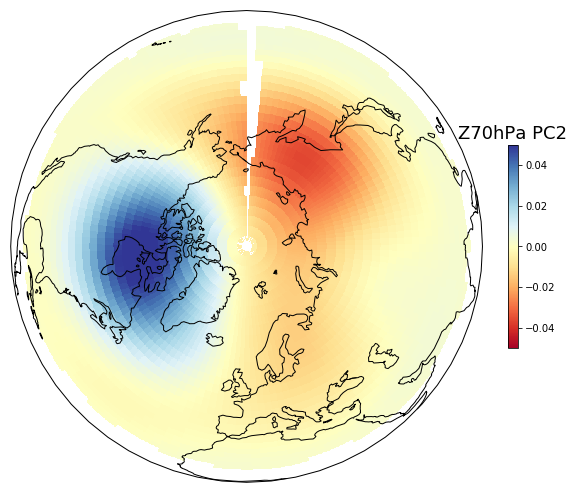

In [31]:
pca_z70 = queryLoadings(this_variable='z70', this_grid_df=grid_df_20N, this_loading='loading_2')

In [32]:
pca_z70.explained_variance_ratio_

array([ 0.66685266,  0.09820125,  0.0846545 ])

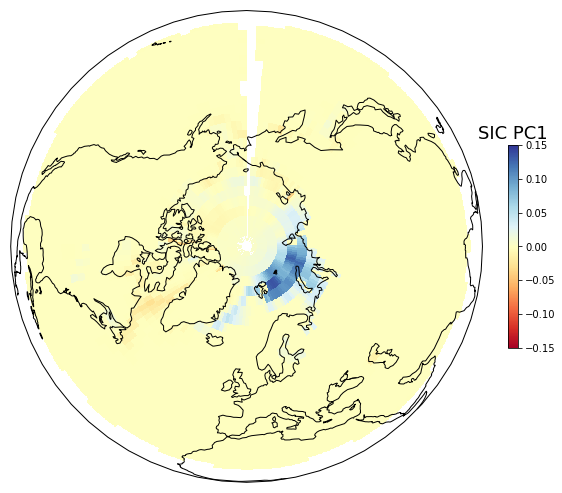

In [33]:
pca_ci = queryLoadings(this_variable='ci', this_grid_df=grid_df_20N, this_loading='loading_1')

In [34]:
pca_ci.explained_variance_ratio_

array([ 0.13260473,  0.08244579,  0.06885804])

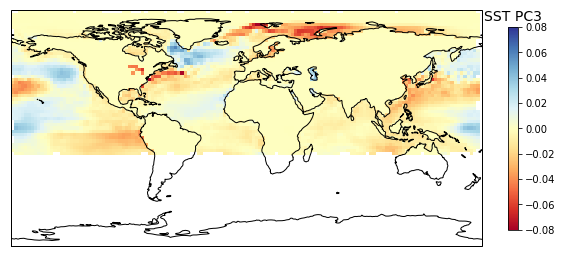

In [35]:
pca_sst = queryLoadings(this_variable='sst', this_grid_df=grid_df_20S, this_loading='loading_3')

In [36]:
pca_sst.explained_variance_ratio_

array([ 0.20967211,  0.0658927 ,  0.05159079])

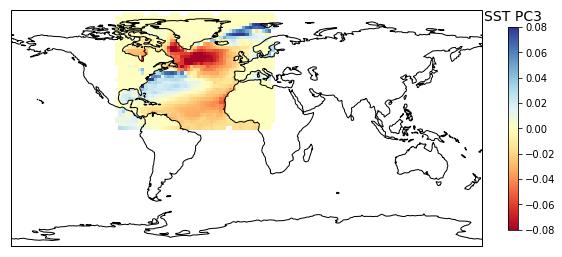

In [37]:
pca_sst_Natl = queryLoadings(this_variable='sst', this_grid_df=grid_df_NAtlantic, this_loading='loading_1')

In [38]:
pca_sst_Natl.explained_variance_ratio_

array([ 0.16312678,  0.09081077,  0.07170466])

In [39]:
def queryScores(this_variable, this_grid_df):
    # Query data anomalies
    grid_ids = this_grid_df.id_grid.values
    res = con_anom.aggregate(pipeline=[ 
    {"$project": {"id_grid": 1, "date": 1, this_variable: 1, "month": {"$month": "$date"}}},
    {"$match": {"month": {"$in": [9, 10, 11, 12, 1, 2]},
                "id_grid": {"$in": grid_ids.tolist()} }},
    {"$project": {"_id": 0, "id_grid": 1, "date": 1, this_variable: 1}} ])    
    anom_df = pd.DataFrame(list(res))

    # Get Principal Component Scores
    X_df = anom_df.pivot(index='date', columns='id_grid', values=this_variable)
    pca = PCA(n_components=3)
    df_scores = pd.DataFrame(pca.fit_transform(X_df), 
                             columns=['PC1_%s' % (this_variable), 
                                      'PC2_%s' % (this_variable), 
                                      'PC3_%s' % (this_variable)], 
                             index=X_df.index)
    return df_scores

scores_z70 = queryScores(this_variable='z70', this_grid_df=grid_df_20N)
scores_z70.head()

,PC1_z70,PC2_z70,PC3_z70
date,,,
1979-01-01,47305.944044,-21384.693316,-20280.483751
1979-02-01,27377.090406,-5627.629663,-24174.825459
1979-09-01,18023.465139,2794.736512,-2092.985110
1979-10-01,14187.255820,-8848.225741,-3218.127655
1979-11-01,27520.923158,-14059.658557,-5650.416198
